In [2]:
import tweepy
import webbrowser
import networkx as nx
import time
import pandas as pd
import csv
import operator
import json
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import collections

In [3]:
F_NAME = 'retweet_data.json'

tweets_read = 0
edge_list   = []
with open(F_NAME,'r') as f:
    for result in f:
        tweet = json.loads(result)
        tweets_read += 1
        if tweet.get('retweeted_status'):
            user    = tweet['user']['screen_name'].lower()
            rt_user = tweet['retweeted_status']['user']['screen_name'].lower()
            edge_list.append((rt_user, user))

print(tweets_read, len(edge_list))

1911 1911


In [4]:
#construct networkx graph
g = nx.DiGraph()
check_added = {}

for edge in edge_list:
    if(edge[0] not in check_added.keys()):
        g.add_node(edge[0])
        check_added[edge[0]] = True
    if(edge[1] not in check_added.keys()):
        g.add_node(edge[1])
        check_added[edge[1]] = True
    g.add_edge(edge[0],edge[1])

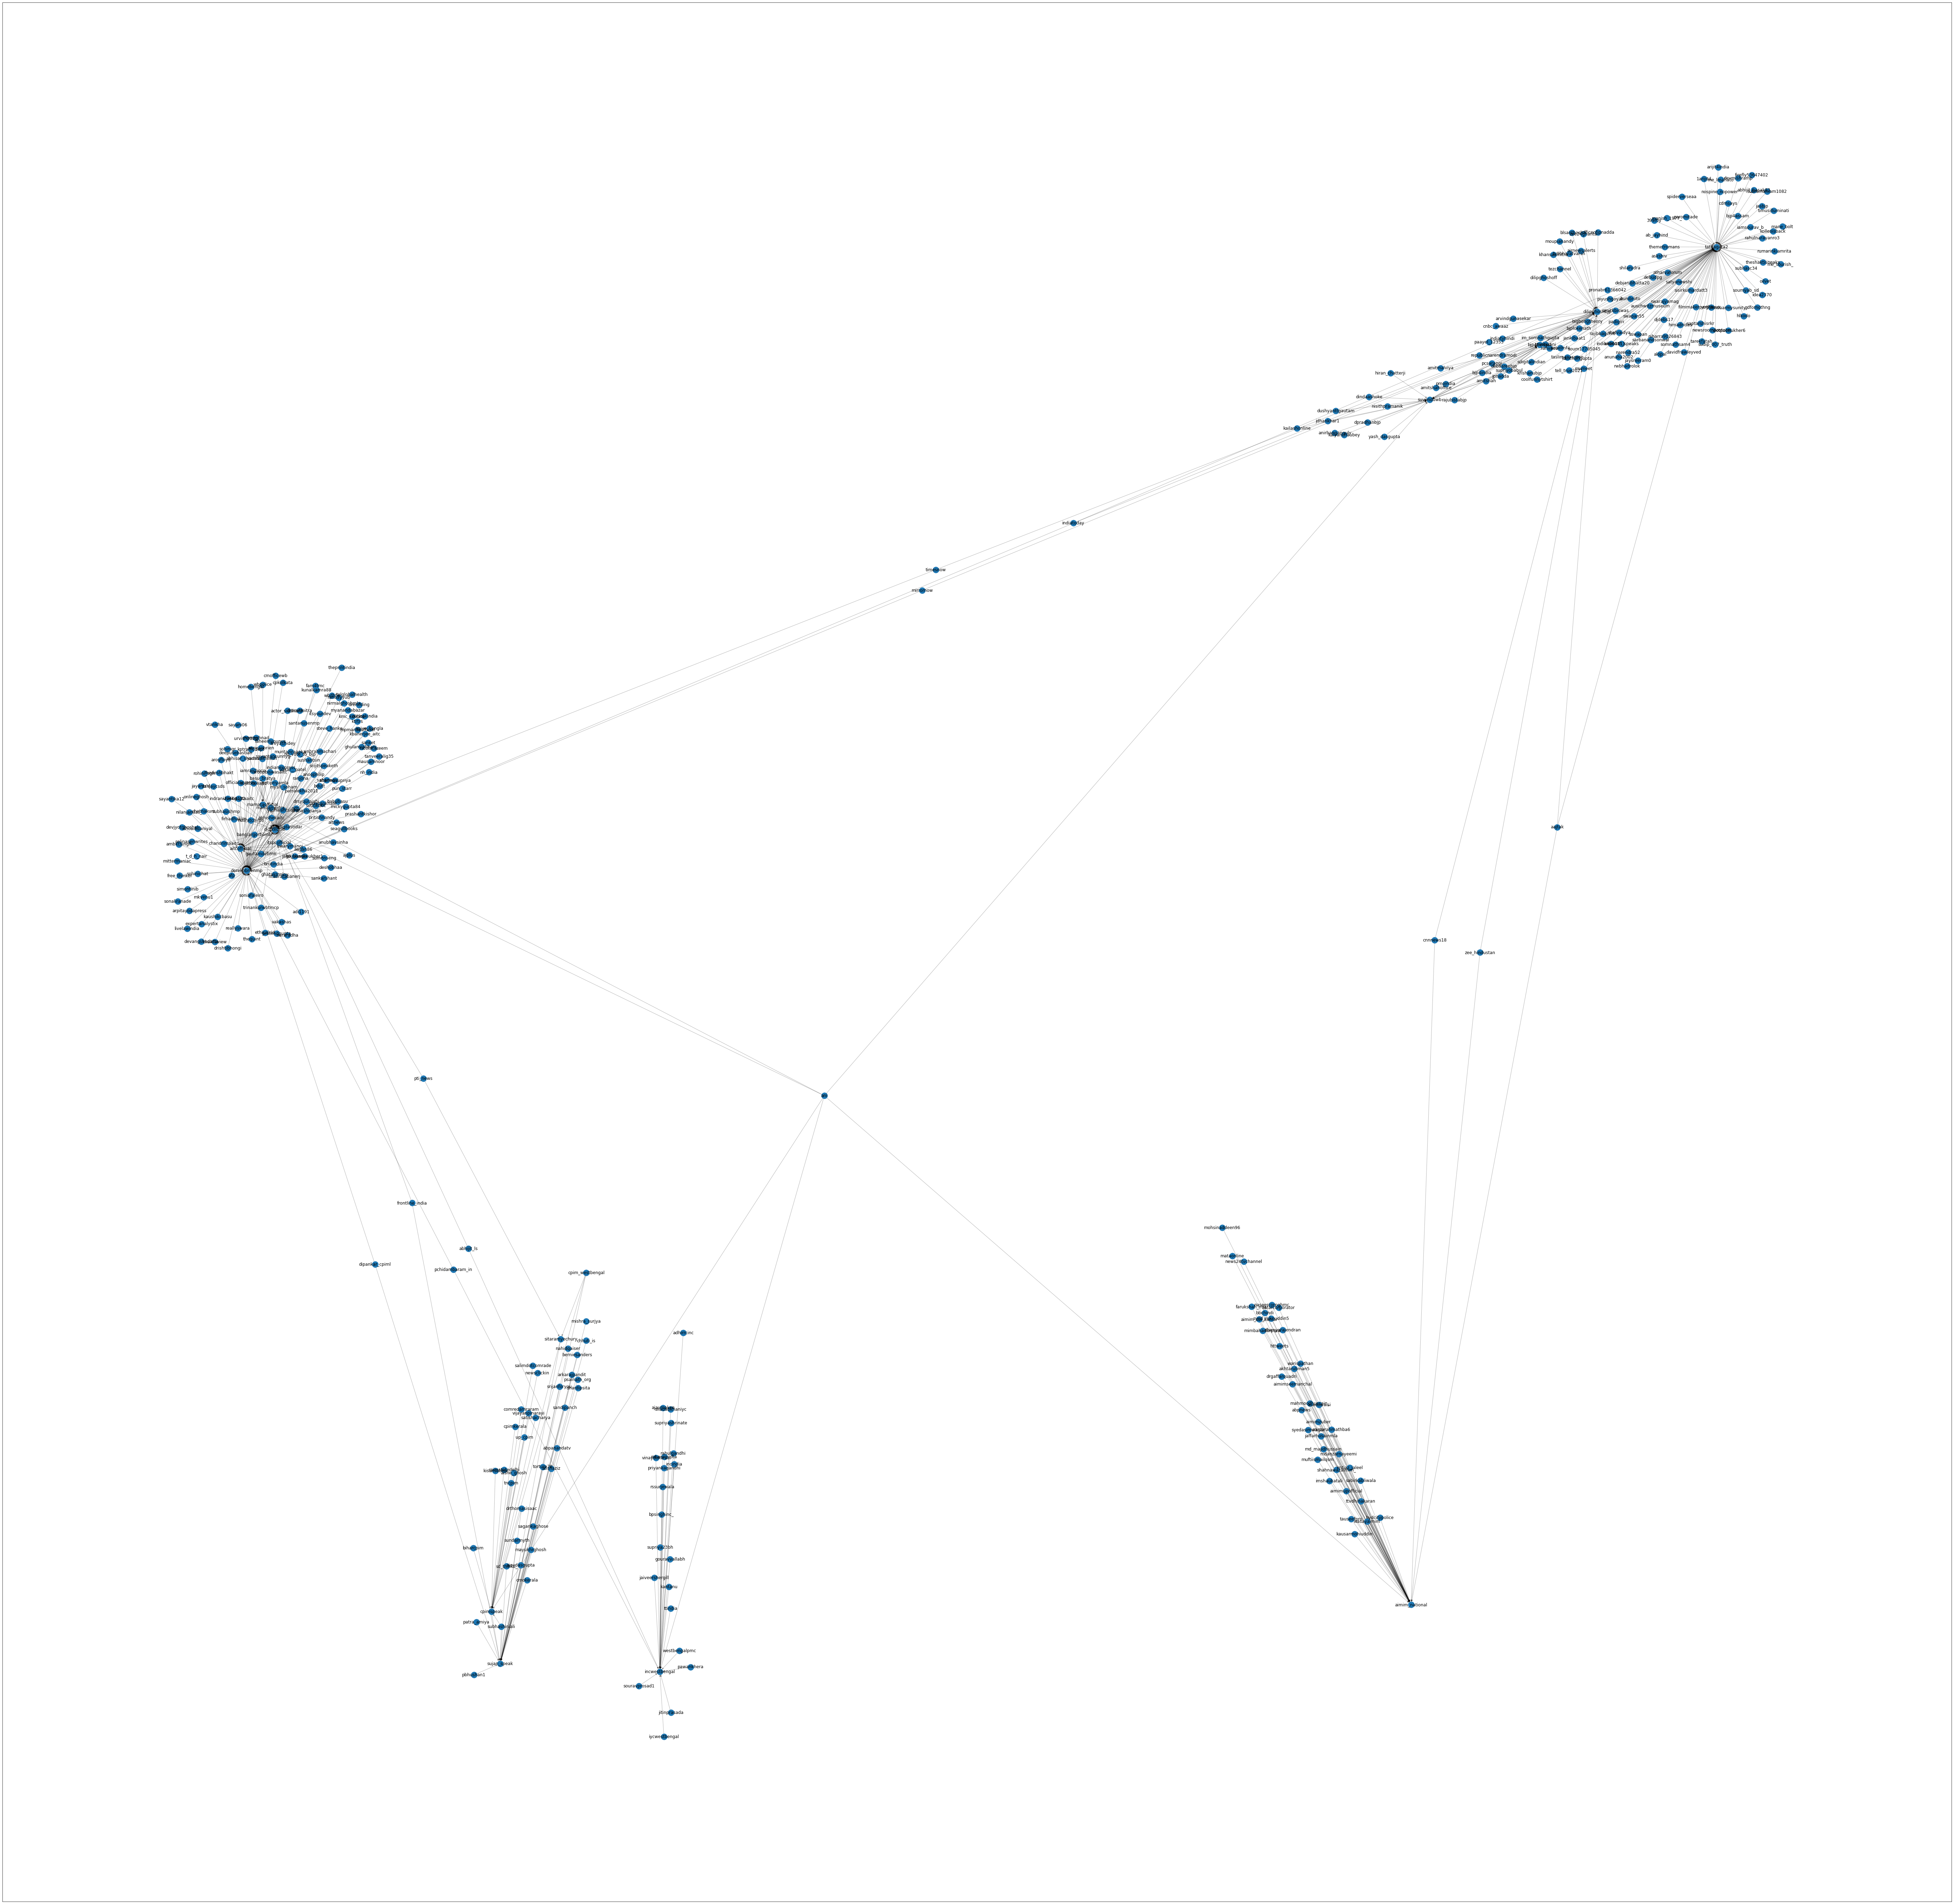

In [7]:
# retweet network
pos = nx.spring_layout(g)
# color the nodes according to their partition
plt.subplots(figsize =(100, 100))
#cmap = cm.get_cmap('plasma', max(partition.values()) + 1)
nx.draw_networkx_nodes(g, pos, partition.keys(),
                       cmap=cmap)
nx.draw_networkx_edges(g, pos, alpha=0.3)
labels = nx.draw_networkx_labels(g, pos)
plt.savefig('./retweet_network.pdf')

0.7465116730384832


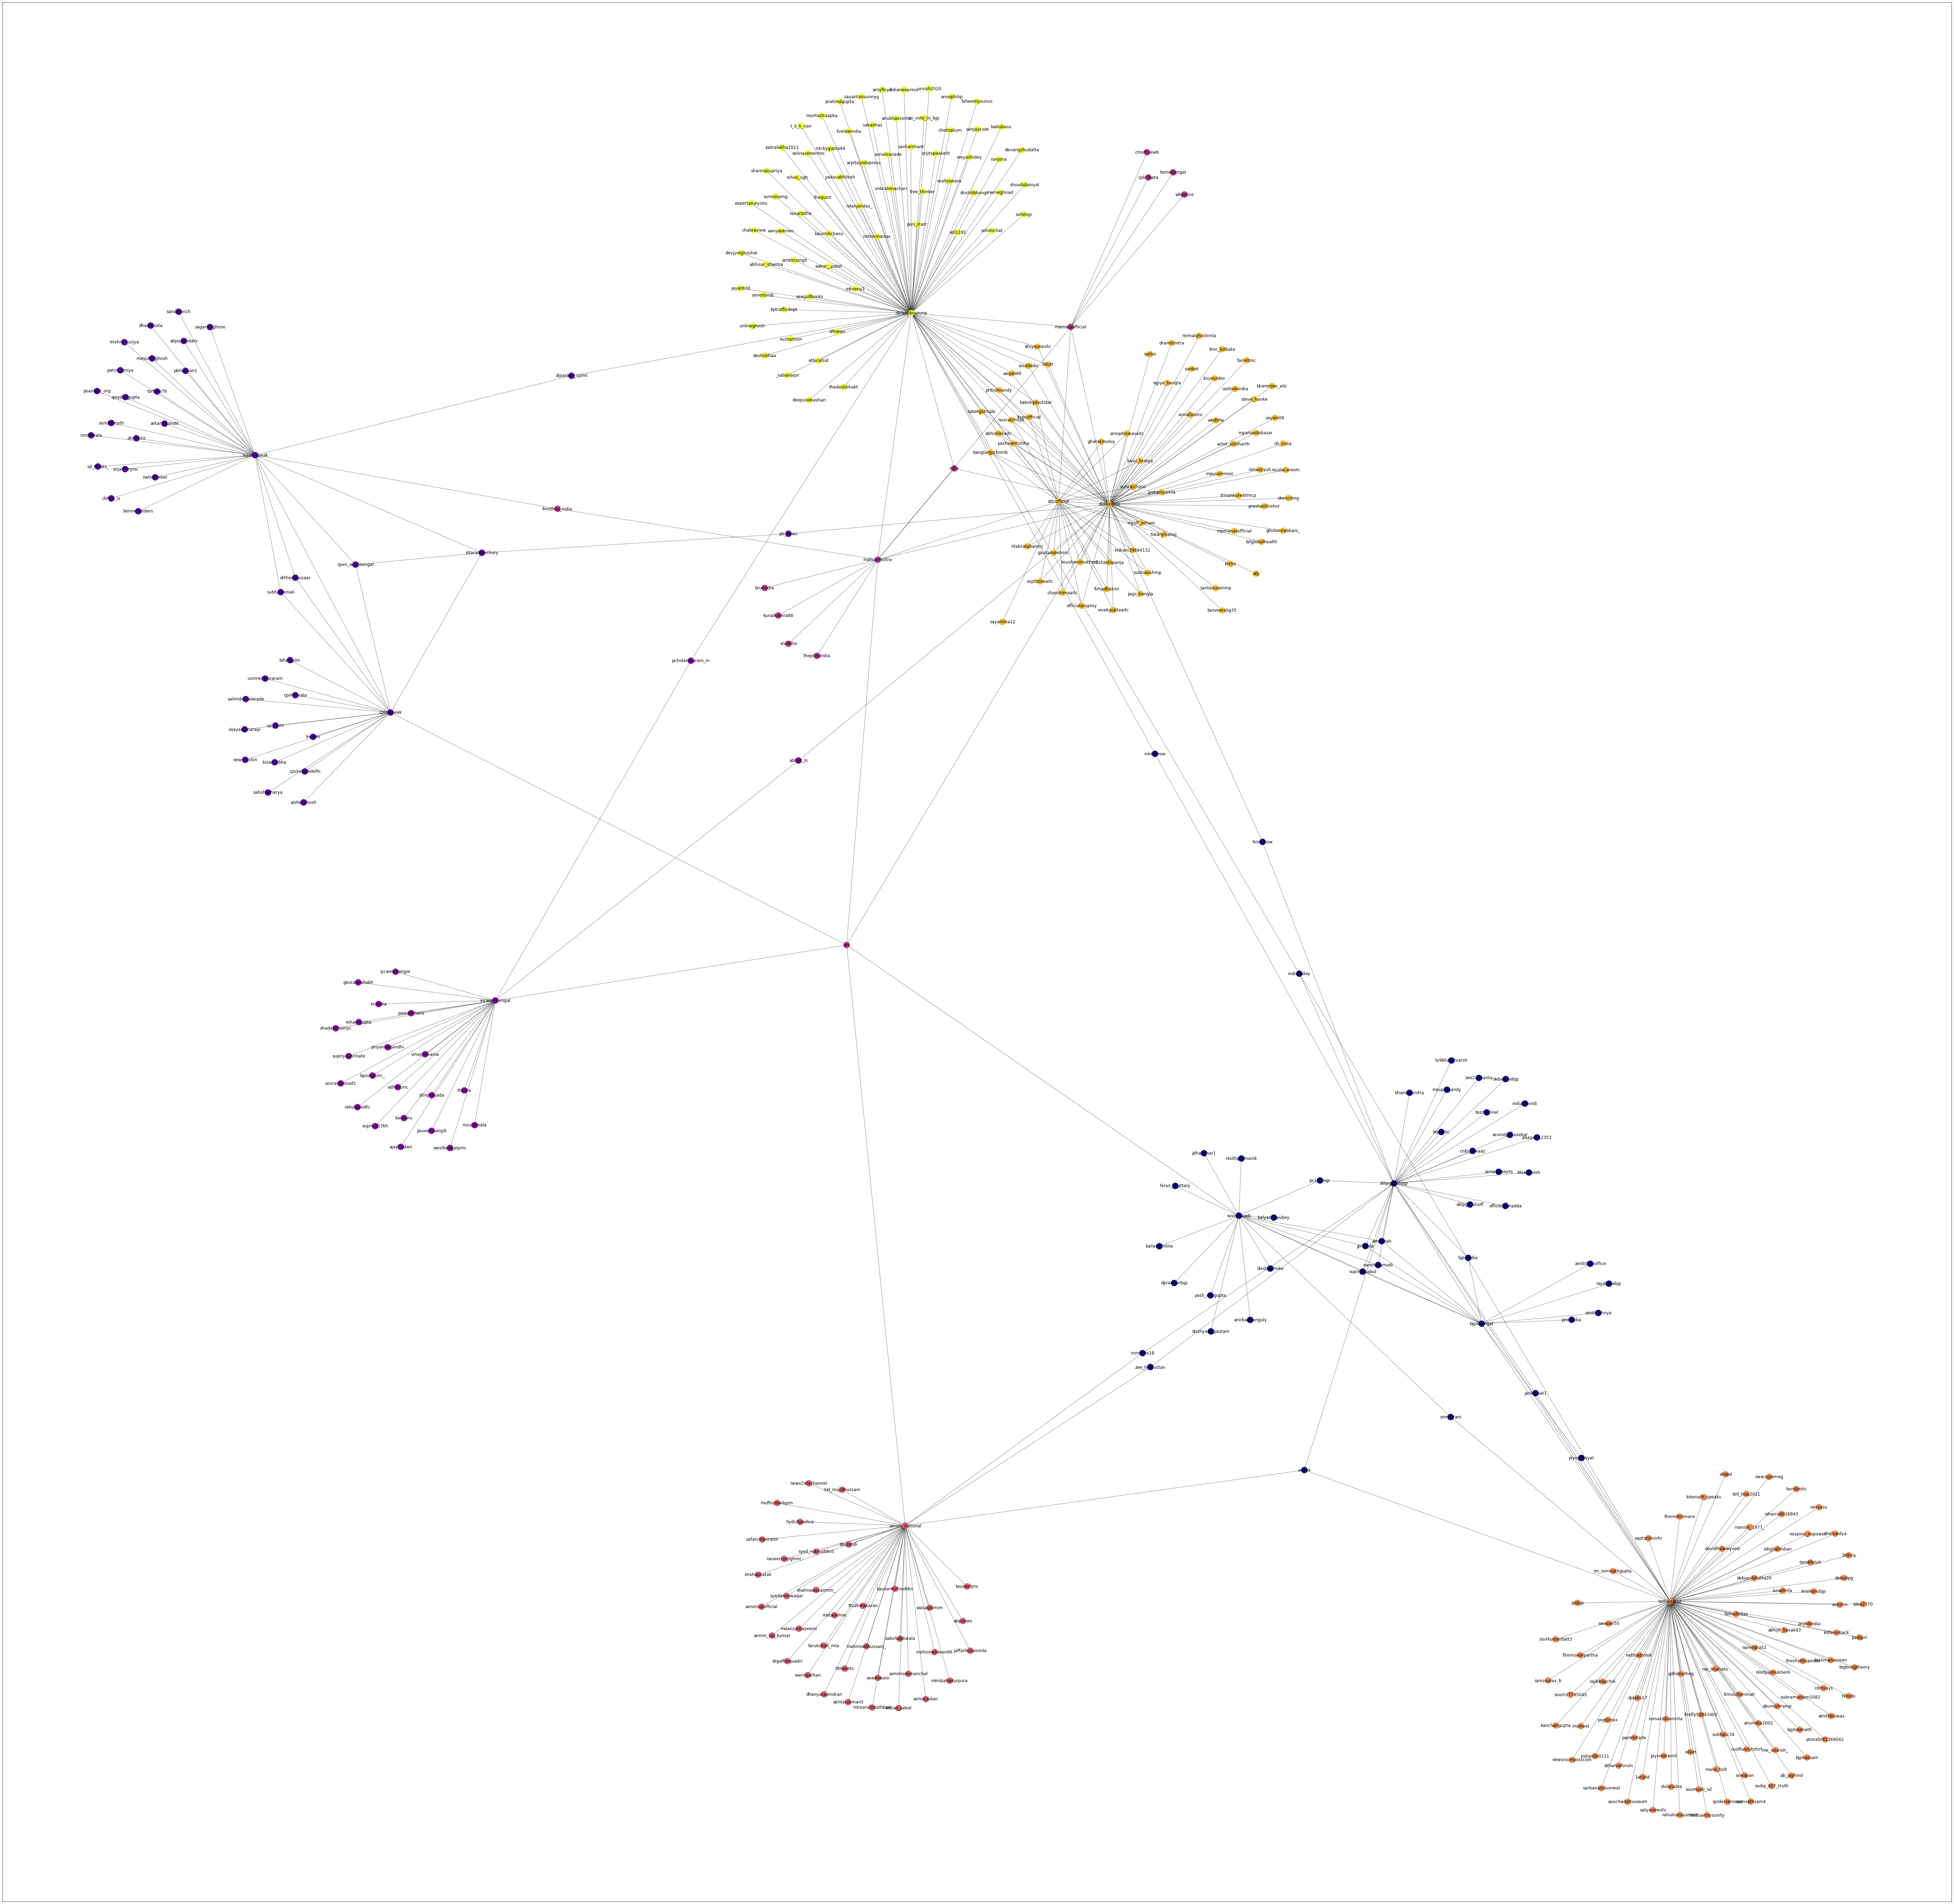

In [6]:
#communities
G = g.to_undirected()

#first compute the best partition
partition = community_louvain.best_partition(G)
print(community_louvain.modularity(partition, G))

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
plt.subplots(figsize =(100, 100))
cmap = cm.get_cmap('plasma', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(),
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
labels = nx.draw_networkx_labels(G, pos)
plt.savefig('./retweet_network_communities.pdf')

In [8]:
#plot degree distribution
def plot_deg_dist(G, dist_type='in'):
    if(dist_type == 'in'):
        degrees = G.in_degree() # list of tuples [(node id, in degree)]
    else:
        degrees = G.out_degree()
    values = {}
    for tup in degrees:
        if(tup[1] in values.keys()):
            values[tup[1]]+=1
        else:
            values[tup[1]]=1
    values = dict(sorted(values.items(), key=lambda item: item[0]))
    print(values)
    vals = [key for key in values.keys()]
    #print(in_vals)
    hist = [values[key] for key in values.keys()]
    plt.figure() # you need to first do 'import pylab as plt' plt.grid(True)
    plt.plot(vals, hist, 'go-') # in-degree plt.plot(out_values, out_hist, 'bv-') # out-degree plt.legend(['In-degree', 'Out-degree']) plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.xlabel('Degree')
    if(dist_type == 'in'):
        plt.title('Retweet Network : In-degree distribution') 
        plt.savefig('./retweet_net_in_degree_distribution.pdf')
    else:
        plt.title('Retweet Network Network : Out-degree distribution')
        plt.savefig('./retweet_net_out_degree_distribution.pdf')

    plt.close()

In [9]:
#plot in-degree distribution
plot_deg_dist(g)
#plot out-degree distribution
plot_deg_dist(g, 'out')

{0: 360, 2: 1, 4: 1, 8: 1, 12: 1, 18: 2, 24: 1, 27: 1, 29: 1, 30: 1, 40: 1, 70: 1, 87: 1, 90: 1}
{0: 3, 1: 306, 2: 46, 3: 17, 4: 1, 6: 1}


In [10]:
#Centrality measures
bet_cen = nx.betweenness_centrality(g)
clos_cen = nx.closeness_centrality(g)
eig_cen = nx.eigenvector_centrality(g)

def get_top_keys(dictionary, top):
    items = dictionary.items()
    items = sorted(items, reverse=True, key=lambda x: x[1]) 
    return map(lambda x: x[0], items[:top])

top_bet_cen = get_top_keys(bet_cen,10) 
top_clo_cen = get_top_keys(clos_cen,10) 
top_eig_cen = get_top_keys(eig_cen,10)

print("Top 10 Central Nodes: Betweenness centrality")
for node_id in top_bet_cen:
     print(node_id)
print('-----------------------------------------------')
print("Top 10 Central Nodes: Closeness centrality")
for node_id in top_clo_cen:
     print(node_id)
print('-----------------------------------------------')
print("Top 10 Central Nodes: Eigen Vector centrality")
for node_id in top_eig_cen:
     print(node_id)

Top 10 Central Nodes: Betweenness centrality
derekobrienmp
didikebolo
dilipghoshbjp
bjp4bengal
suvenduwb
mahuamoitra
mamataofficial
cpimspeak
aitcofficial
sitaramyechury
-----------------------------------------------
Top 10 Central Nodes: Closeness centrality
derekobrienmp
didikebolo
tathagata2
aitcofficial
aimim_national
sujan_speak
dilipghoshbjp
bjp4bengal
incwestbengal
suvenduwb
-----------------------------------------------
Top 10 Central Nodes: Eigen Vector centrality
derekobrienmp
didikebolo
aitcofficial
tathagata2
bjp4bengal
dilipghoshbjp
suvenduwb
sujan_speak
cpimspeak
mahuamoitra


In [11]:
#Clustering coefficient
print("Average Clustering Coefficient: ", nx.average_clustering(g))

Average Clustering Coefficient:  0.10425546724871924


In [12]:
print("Degree Assortativity Coefficient: ", nx.degree_assortativity_coefficient(g))

Degree Assortativity Coefficient:  -0.20173571185906305


### VoteRank
Select a list of influential nodes in a graph using VoteRank algorithm

VoteRankcomputes a ranking of the nodes in a graph G based on a voting scheme. With VoteRank, all nodes vote for each of its in-neighbours and the node with the highest votes is elected iteratively. The voting ability of out-neighbors of elected nodes is decreased in subsequent turns.

Zhang, J.-X. et al. (2016). Identifying a set of influential spreaders in complex networks. Sci. Rep. 6, 27823; doi: 10.1038/srep27823.

In [13]:
print("VoteRank: ", nx.voterank(g, number_of_nodes=None))

VoteRank:  ['ani', 'indiatoday', 'cpim_westbengal', 'mamataofficial', 'jpnadda', 'piyushgoyal', 'zee_hindustan', 'abhishekaitc', 'drthomasisaac', 'pti_news', 'rahulgandhi']


In [14]:
pagerank_dict = nx.pagerank(g, alpha=0.9)
pagerank_dict = dict( sorted(pagerank_dict.items(), key=operator.itemgetter(1),reverse=True))
print("PageRank: ", pagerank_dict)

PageRank:  {'tathagata2': 0.35664005374599617, 'derekobrienmp': 0.19352239644585176, 'didikebolo': 0.12804368230883573, 'aitcofficial': 0.12086163210813536, 'bjp4bengal': 0.015173505992429772, 'aimim_national': 0.011825184891903118, 'sujan_speak': 0.011330888405692624, 'dilipghoshbjp': 0.01120798512916091, 'suvenduwb': 0.008757870112282937, 'cpimspeak': 0.008625553074556529, 'incwestbengal': 0.007129131109553667, 'mahuamoitra': 0.0022238272487918554, 'mamataofficial': 0.0015653282587266006, 'sitaramyechury': 0.0005954910645457354, 'bjp4india': 0.0003402707502876129, 'jpnadda': 0.0003402707502876129, 'amitshah': 0.0003402707502876129, 'narendramodi': 0.0003402707502876129, 'piyushgoyal': 0.0003402707502876129, 'supriyobabul': 0.0003402707502876129, 'amitmalviya': 0.0003402707502876129, 'pmoindia': 0.0003402707502876129, 'amitshahoffice': 0.0003402707502876129, 'rajubistabjp': 0.0003402707502876129, 'blsanthosh': 0.0003402707502876129, 'airnewsalerts': 0.0003402707502876129, 'tv9bharatva

In [15]:
#top-k page ranks
k = 20
count = 0
print("Top",k,"PageRanks: \n")
for key in pagerank_dict.keys():
    print(key)
    if count == k:
        break
    count+=1

Top 20 PageRanks: 

tathagata2
derekobrienmp
didikebolo
aitcofficial
bjp4bengal
aimim_national
sujan_speak
dilipghoshbjp
suvenduwb
cpimspeak
incwestbengal
mahuamoitra
mamataofficial
sitaramyechury
bjp4india
jpnadda
amitshah
narendramodi
piyushgoyal
supriyobabul
amitmalviya


In [16]:
print(g.edges())

[('bjp4india', 'bjp4bengal'), ('bjp4india', 'dilipghoshbjp'), ('bjp4bengal', 'dilipghoshbjp'), ('bjp4bengal', 'suvenduwb'), ('bjp4bengal', 'tathagata2'), ('jpnadda', 'bjp4bengal'), ('jpnadda', 'dilipghoshbjp'), ('jpnadda', 'suvenduwb'), ('amitshah', 'bjp4bengal'), ('amitshah', 'dilipghoshbjp'), ('amitshah', 'suvenduwb'), ('narendramodi', 'bjp4bengal'), ('narendramodi', 'dilipghoshbjp'), ('narendramodi', 'suvenduwb'), ('piyushgoyal', 'bjp4bengal'), ('piyushgoyal', 'tathagata2'), ('supriyobabul', 'bjp4bengal'), ('supriyobabul', 'dilipghoshbjp'), ('supriyobabul', 'suvenduwb'), ('dilipghoshbjp', 'bjp4bengal'), ('dilipghoshbjp', 'tathagata2'), ('amitmalviya', 'bjp4bengal'), ('pmoindia', 'bjp4bengal'), ('amitshahoffice', 'bjp4bengal'), ('suvenduwb', 'bjp4bengal'), ('rajubistabjp', 'bjp4bengal'), ('blsanthosh', 'dilipghoshbjp'), ('airnewsalerts', 'dilipghoshbjp'), ('tv9bharatvarsh', 'dilipghoshbjp'), ('debasreebjp', 'dilipghoshbjp'), ('dilipghoshoff', 'dilipghoshbjp'), ('arvindgunasekar', 'di